# ARIMA, SARIMA and SARIMAX - Wind Data


# ARIMA

The traditional ARIMA model makes the assumption that historical data can be used to forecast values at following time steps.
ARIMA essentially combines these naive forecasting methods: <br>
1.Auto Regression:
Utilizes one or more previous values to predict the future through autoregression. The amount of values used is referred to as the "order" (for example, order 2 means the value from yesterday and the day before is used). <br>
2.Integration: The process of integrating diminishes seasonality. The "order" is how many degrees of differencing are used to lessen seasonality. <br>
3.Moving Average - The projected values are modified using the Moving Average of the historical data. As it employs the moving average rather than the actual numbers from the past, this has the effect of "smoothing" the historical data. The 'order' is the number of days in the moving average window.



In [201]:
# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")

In [202]:
# Import data
df = pd.read_csv("sample_data/gen-by-fuel-cleaned.csv",parse_dates =True)
df

,Time_Stamp,Fuel_Type,MW_Generated,Fuel_Percentage_of_Total
0,1/1/2020 10:00:00 AM,Coal,11851.4,0.14
1,1/1/2020 10:00:00 AM,Gas,33401.4,0.39
2,1/1/2020 10:00:00 AM,Hydro,1236.3,0.01
3,1/1/2020 10:00:00 AM,Multiple Fuels,3.2,0.00
4,1/1/2020 10:00:00 AM,Nuclear,33038.6,0.38
...,...,...,...,...
192396,9/9/2021 9:00:00 PM,Other,39.4,0.00
192397,9/9/2021 9:00:00 PM,Other Renewables,643.8,0.00
192398,9/9/2021 9:00:00 PM,Solar,9.6,0.00
192399,9/9/2021 9:00:00 PM,Storage,0.0,0.00


Text(0.07, 1, 'Missing data check')

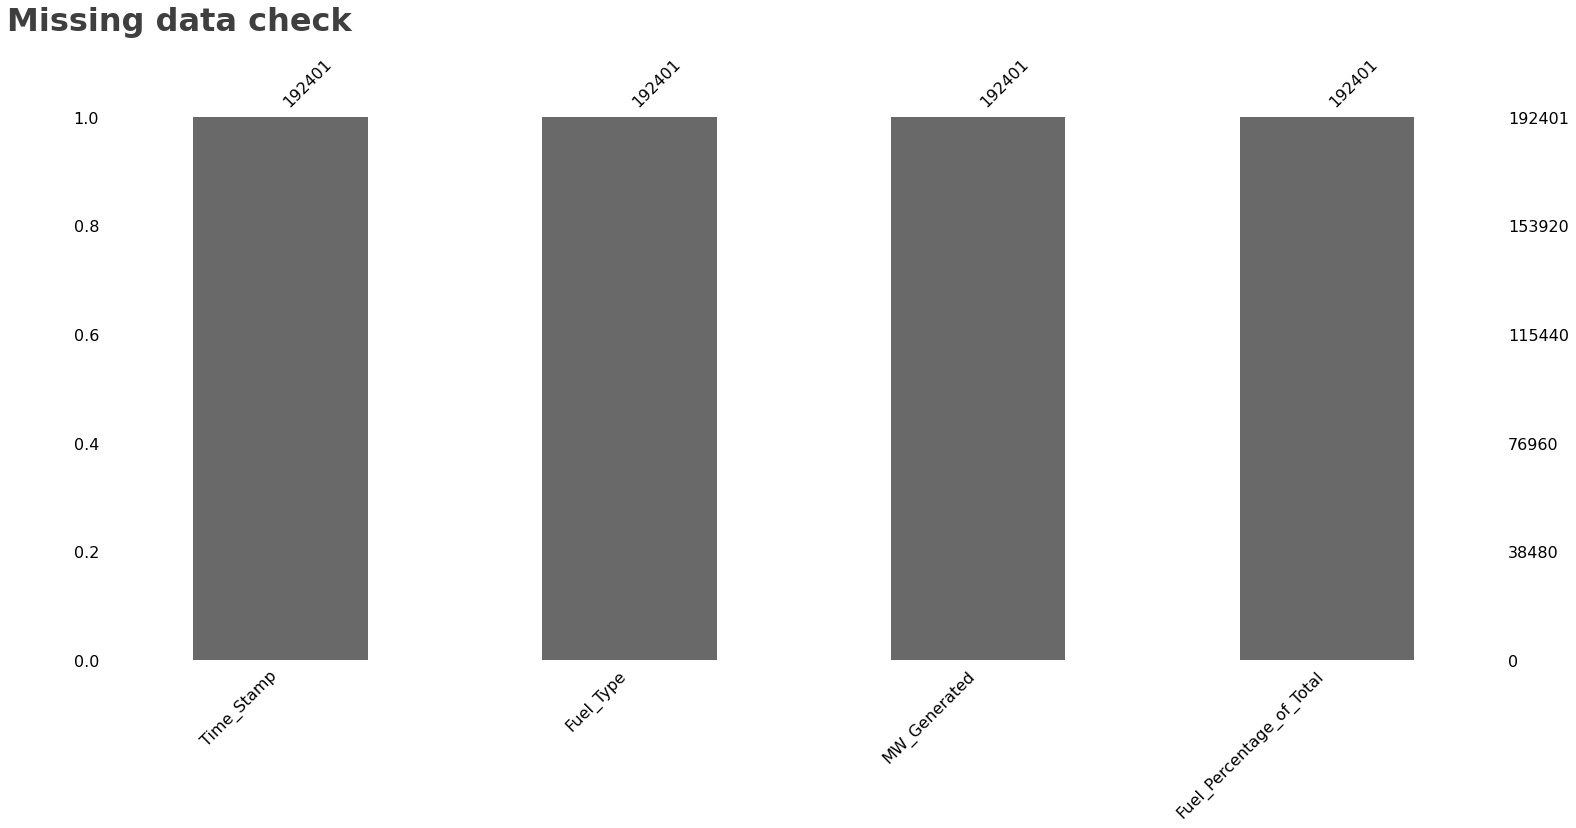

In [203]:
import missingno as msno
ax, fig = plt.subplots(figsize=(10,5))

msno.bar(df)

ax.text(0.07,1, s="Missing data check", fontsize=32, weight="bold", alpha=0.75)

In [204]:
#Selecting wind data only
df=df[df['Fuel_Type']=='Wind']
df=df.drop(['Fuel_Type','Fuel_Percentage_of_Total'],axis=1) #droping unused columns
df

,Time_Stamp,MW_Generated
10,1/1/2020 10:00:00 AM,4443.8
21,1/1/2020 10:00:00 PM,7696.1
32,1/1/2020 11:00:00 AM,4878.3
43,1/1/2020 11:00:00 PM,7672.3
54,1/1/2020 12:00:00 AM,4964.2
...,...,...
192356,9/9/2021 7:00:00 PM,1114.3
192367,9/9/2021 8:00:00 AM,821.6
192378,9/9/2021 8:00:00 PM,1010.9
192389,9/9/2021 9:00:00 AM,286.6


In [205]:
#string to date format
df['Date'] = pd.to_datetime(df['Time_Stamp']).dt.date

df=df.drop(['Time_Stamp'],axis=1)

df_grouped = df.groupby(['Date'],as_index=False).sum()
df_grouped = df_grouped.set_index(['Date'])
df_grouped


,MW_Generated
Date,
2020-01-01,133815.5
2020-01-02,130072.1
2020-01-03,22495.1
2020-01-04,71593.6
2020-01-05,136251.6
...,...
2021-12-27,126366.0
2021-12-28,85269.1
2021-12-29,45602.2


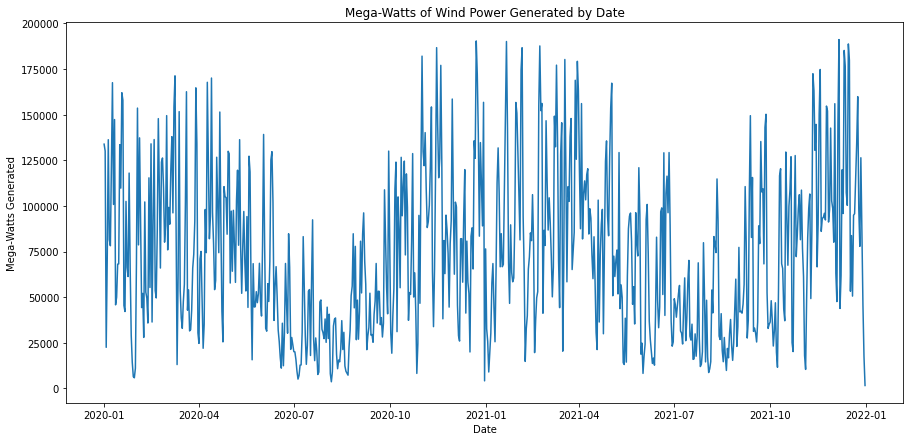

In [206]:
plt.figure(figsize=(15,7))
plt.title("Mega-Watts of Wind Power Generated by Date")
plt.xlabel('Date')
plt.ylabel('Mega-Watts Generated')
plt.plot(df_grouped)
plt.show()

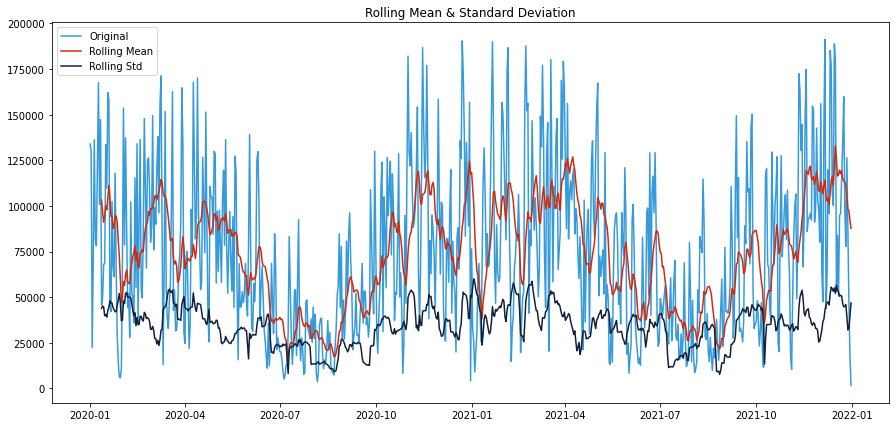

In [207]:
#Determine rolling statistics
dg=df_grouped
dg["rolling_avg"] = dg["MW_Generated"].rolling(window=12).mean() #window size 12 denotes 12 months, giving rolling mean at yearly level
dg["rolling_std"] = dg["MW_Generated"].rolling(window=12).std()

#Plot rolling statistics
plt.figure(figsize=(15,7))
plt.plot(dg["MW_Generated"], color='#379BDB', label='Original')
plt.plot(dg["rolling_avg"], color='#D22A0D', label='Rolling Mean')
plt.plot(dg["rolling_std"], color='#142039', label='Rolling Std')
plt.legend(loc='best')
plt.title('Rolling Mean & Standard Deviation')
plt.show(block=False)

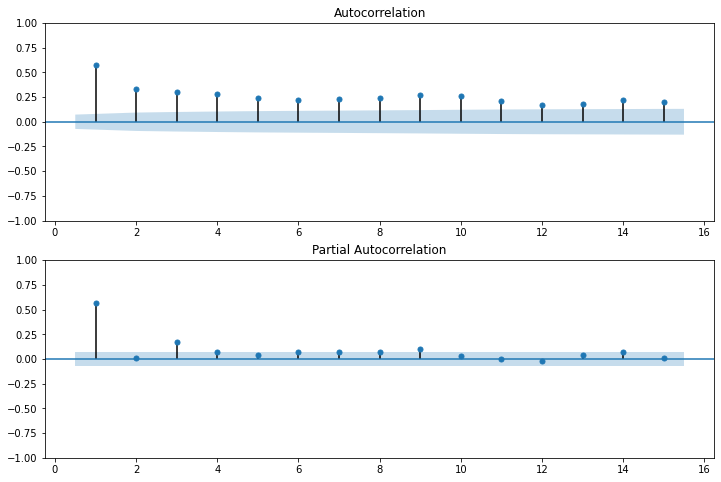

In [208]:
# Import ACF and PCF functions
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
# Create figure
fig, (ax1, ax2) = plt.subplots(2,1, figsize=(12,8))
 
# Plot the ACF on ax1
plot_acf(df_grouped['MW_Generated'], lags=15, zero=False, ax=ax1)

# Plot the PACF of on ax2
plot_pacf(df_grouped['MW_Generated'], lags=15, zero=False, ax=ax2)

plt.show()

In [209]:
#Augmented Dickey–Fuller test:
from statsmodels.tsa.stattools import adfuller
print('Results of Dickey Fuller Test:')
dftest = adfuller(df_grouped['MW_Generated'], autolag='AIC')

dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
for key,value in dftest[4].items():
    dfoutput['Critical Value (%s)'%key] = value
    
print(dfoutput)

Results of Dickey Fuller Test:
Test Statistic                  -5.065675
p-value                          0.000016
#Lags Used                       8.000000
Number of Observations Used    722.000000
Critical Value (1%)             -3.439440
Critical Value (5%)             -2.865551
Critical Value (10%)            -2.568906
dtype: float64


In [210]:
!pip install pmdarima
from pmdarima.arima import auto_arima
import pmdarima as pm
ARIMA_model = pm.auto_arima(df_grouped['MW_Generated'], 
                      start_p=1, 
                      start_q=1,
                      test='adf', # use adftest to find optimal 'd'
                      max_p=3, max_q=3, # maximum p and q
                      m=1, # frequency of series (if m==1, seasonal is set to FALSE automatically)
                      d=None,# let model determine 'd'
                      seasonal=False, # No Seasonality for standard ARIMA
                      trace=False, #logs 
                      error_action='warn', #shows errors ('ignore' silences these)
                      suppress_warnings=True,
                      stepwise=True)
print(ARIMA_model.summary())

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  731
Model:               SARIMAX(1, 0, 3)   Log Likelihood               -8697.749
Date:                Sun, 30 Oct 2022   AIC                          17405.498
Time:                        09:39:43   BIC                          17428.470
Sample:                    01-01-2020   HQIC                         17414.361
                         - 12-31-2021                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.9991      0.001    850.171      0.000       0.997       1.001
ma.L1         -0.4735      0.038

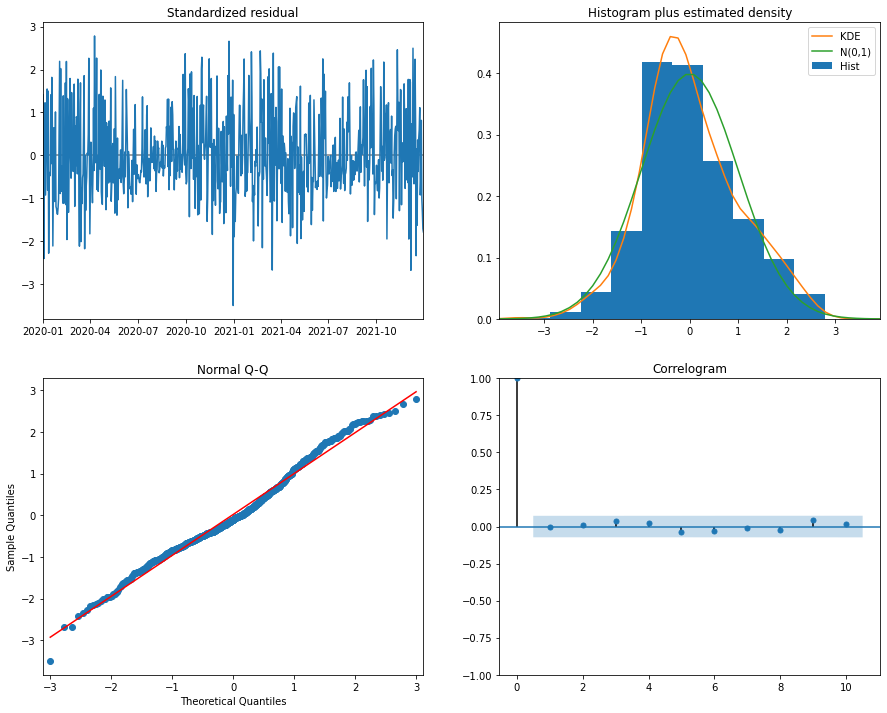

In [211]:
ARIMA_model.plot_diagnostics(figsize=(15,12))
plt.show()

## Forecasting for the next 365 days

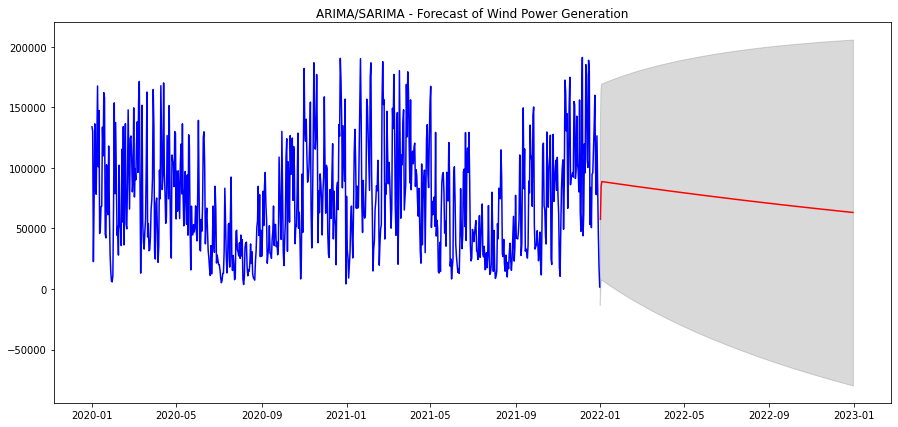

In [212]:
def forecast(ARIMA_model, periods=365): #Forecasting for the next 365 days
    # Forecast
    n_periods = periods
    fitted, confint = ARIMA_model.predict(n_periods=n_periods, return_conf_int=True)
    index_of_fc = pd.date_range(df_grouped.index[-1] + pd.DateOffset(day=31), periods = n_periods, freq='D')

    # make series for plotting purpose
    fitted_series = pd.Series(fitted, index=index_of_fc)
    lower_series = pd.Series(confint[:, 0], index=index_of_fc)
    upper_series = pd.Series(confint[:, 1], index=index_of_fc)
    
    # Plot
    plt.figure(figsize=(15,7))
    plt.plot(df_grouped["MW_Generated"], color='blue')
    plt.plot(fitted_series, color='red')
    plt.fill_between(lower_series.index, 
                    lower_series, 
                    upper_series, 
                    color='k', alpha=.15)

    plt.title("ARIMA/SARIMA - Forecast of Wind Power Generation")
    plt.show()


forecast(ARIMA_model)

## Performance Evaluation - ARIMA

In [213]:
from sklearn.metrics import mean_absolute_error
n_periods = 731
fitted, confint = ARIMA_model.predict(n_periods=n_periods, return_conf_int=True)
print("Mean Absolute Error:")
mean_absolute_error(df_grouped['MW_Generated'], fitted)


Mean Absolute Error:


38302.613729801524

In [214]:
from sklearn.metrics import mean_squared_error
print("Mean Squared Error:")
mean_squared_error(df_grouped['MW_Generated'], fitted)

Mean Squared Error:


2253698827.4272156

In [215]:
from math import sqrt
print("Root Mean Squared Error:")
sqrt(mean_squared_error(df_grouped['MW_Generated'], fitted))

Root Mean Squared Error:


47473.137956398205

# SARIMA
Now let's try the same strategy as we did above, except let's use a SARIMA model so that we can account for seasonality.

In [216]:
SARIMA_model = pm.auto_arima(df_grouped["MW_Generated"], start_p=1, start_q=1,
                         test='adf',
                         max_p=3, max_q=3, 
                         m=6, #frequncy of the cycle
                         start_P=0, 
                         seasonal=True, #set to seasonal
                         d=None, 
                         D=1, #order of the seasonal differencing
                         trace=False,
                         error_action='ignore',  
                         suppress_warnings=True, 
                         stepwise=True)
print(SARIMA_model.summary())

                                      SARIMAX Results                                      
Dep. Variable:                                   y   No. Observations:                  731
Model:             SARIMAX(3, 0, 0)x(0, 1, [1], 6)   Log Likelihood               -8701.818
Date:                             Sun, 30 Oct 2022   AIC                          17413.635
Time:                                     09:41:37   BIC                          17436.566
Sample:                                 01-01-2020   HQIC                         17422.485
                                      - 12-31-2021                                         
Covariance Type:                               opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.5594      0.065      8.600      0.000       0.432       0.687
ar.L2         -0.0956      

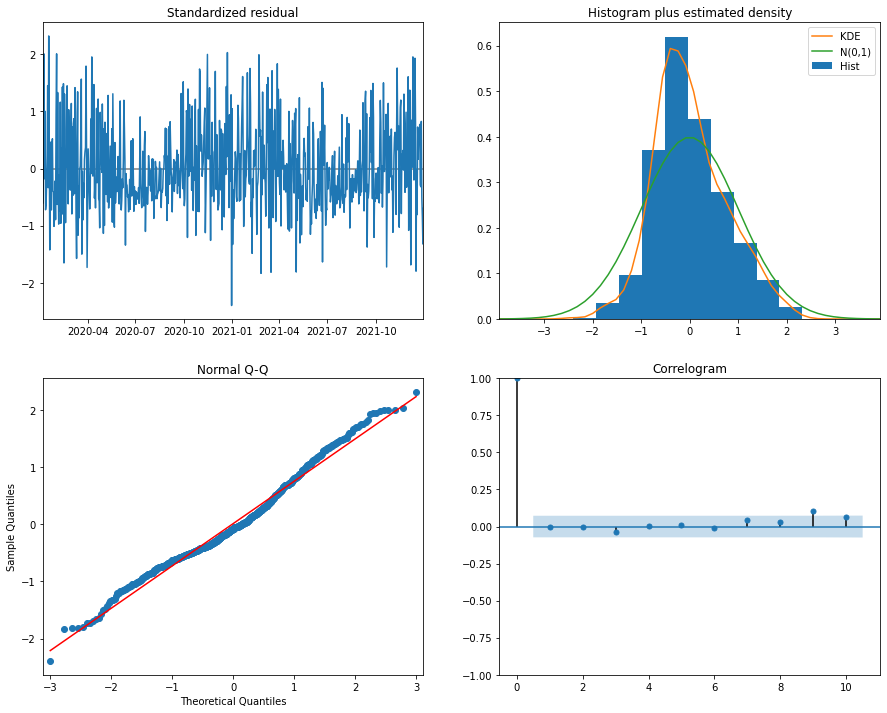

In [217]:
SARIMA_model.plot_diagnostics(figsize=(15,12))
plt.show()

## Forecasting for the next 365 days

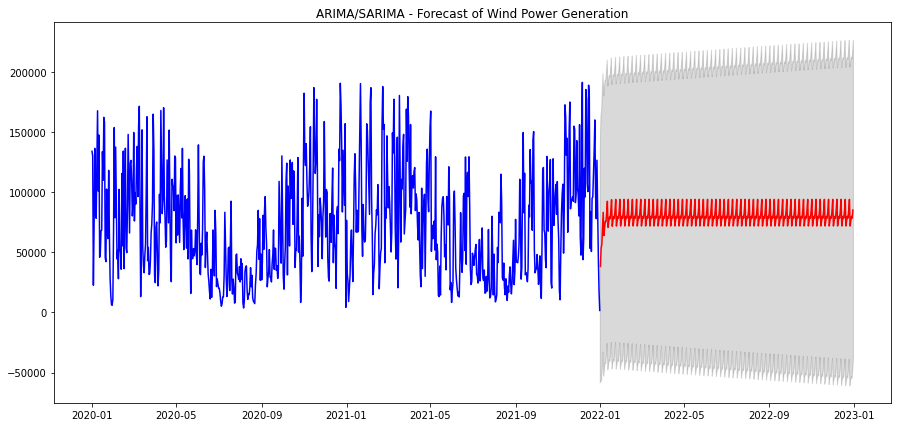

In [218]:
forecast(SARIMA_model)

## Performance Evaluation - SARIMA

In [219]:
from sklearn.metrics import mean_absolute_error
n_periods = 731
fitted, confint = SARIMA_model.predict(n_periods=n_periods, return_conf_int=True)
print("Mean Absolute Error:")
mean_absolute_error(df_grouped['MW_Generated'], fitted)


Mean Absolute Error:


38237.11135918151

In [220]:
from sklearn.metrics import mean_squared_error
print("Mean Squared Error:")
mean_squared_error(df_grouped['MW_Generated'], fitted)

Mean Squared Error:


2069977227.0604875

In [221]:
from math import sqrt
print("Root Mean Squared Error:")
sqrt(mean_squared_error(df_grouped['MW_Generated'], fitted))

Root Mean Squared Error:


45497.00239642704

# SARIMAX
SARIMAX, which incorporates trends and seasonality as previously mentioned, gives the ARIMA model a "seasonality" flavor.


The main hyperparameters are SARIMAX(p,d,q)(P,D,Q,m):

autoregression order (p)
Integrating order (d)
moving average window (q)
Seasonal autoregressive order (P)
Seasonal difference order (D)
Seasonal moving average order (Q)
number of time steps for a single seasonal period (m)
The X is the exogenous (external) variables to the model - they are optional 

In [222]:
#adding exogenous variable
df_grouped['Date_index'] = df_grouped.index
df_grouped['Month'] = df_grouped['Date_index'].apply(lambda x: x.month) #taking month number as exogenous variable

# SARIMAX Model
SARIMAX_model = pm.auto_arima(df_grouped[['MW_Generated']], exogenous=df_grouped[['Month']],
                           start_p=1, start_q=1,
                           test='adf',
                           max_p=3, max_q=3, m=6,
                           start_P=0, seasonal=True,
                           d=None, D=1, 
                           trace=False,
                           error_action='ignore',  
                           suppress_warnings=True, 
                           stepwise=True)

SARIMAX_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                      
===========================================================================================
Dep. Variable:                                   y   No. Observations:                  731
Model:             SARIMAX(3, 0, 0)x(0, 1, [1], 6)   Log Likelihood               -8701.818
Date:                             Sun, 30 Oct 2022   AIC                          17413.635
Time:                                     09:43:18   BIC                          17436.566
Sample:                                 01-01-2020   HQIC                         17422.485
                                      - 12-31-2021                                         
Covariance Type:                               opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.5594      0.065      8.600      0.000       0.432       0.687
ar.L2         -0.0956      0.067     -1.422      0.155      -0.227       0.036
ar.L3          0.1550      0.062      2.492      0.013       0.033       0.277
ma.S.L6       -0.9389      0.031    -30.582      0.000      -0.999      -0.879
sigma2      2.412e+09   3.23e-12   7.47e+20      0.000    2.41e+09    2.41e+09
===================================================================================
Ljung-Box (L1) (Q):                   0.03   Jarque-Bera (JB):                19.18
Prob(Q):                              0.86   Prob(JB):                         0.00
Heteroskedasticity (H):               0.93   Skew:                             0.39
Prob(H) (two-sided):                  0.56   Kurtosis:                         3.11
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 9.24e+36. Standard errors may be unstable.
"""

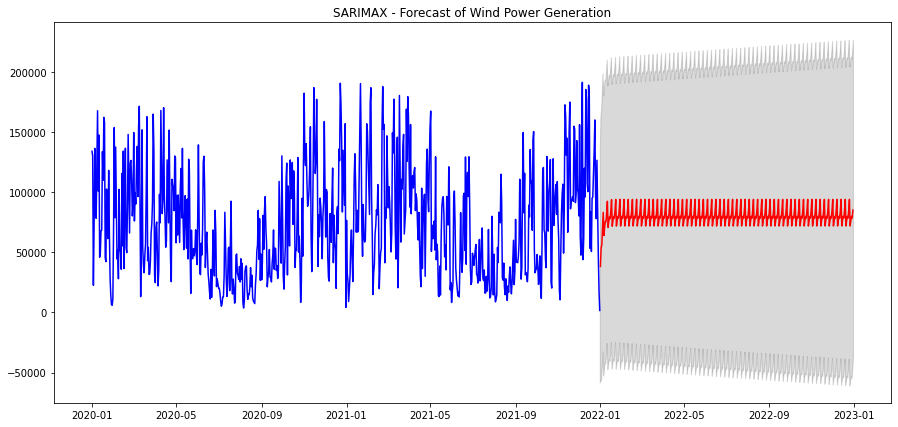

In [223]:
def sarimax_forecast(SARIMAX_model, periods=365):
    # Forecast
    n_periods = periods
    #df_grouped['Month'] = pd.to_datetime(df_grouped['Month'])
    forecast_df = abs(pd.DataFrame({"Month":pd.date_range(df_grouped.index[-1], periods = n_periods, freq='D').day},
                    index = pd.date_range(df_grouped.index[-1]+ pd.DateOffset(day=31), periods = n_periods, freq='D')))

    fitted, confint = SARIMAX_model.predict(n_periods=n_periods, 
                                            return_conf_int=True,
                                            exogenous=forecast_df[['Month']])
    index_of_fc = pd.date_range(df_grouped.index[-1] + pd.DateOffset(day=31), periods = n_periods, freq='D')

    # make series for plotting purpose
    fitted_series = pd.Series(fitted, index=index_of_fc)
    lower_series = pd.Series(confint[:, 0], index=index_of_fc)
    upper_series = pd.Series(confint[:, 1], index=index_of_fc)

    # Plot
    plt.figure(figsize=(15,7))
    plt.plot(df_grouped["MW_Generated"], color='blue')
    plt.plot(fitted_series, color='red')
    plt.fill_between(lower_series.index, 
                    lower_series, 
                    upper_series, 
                    color='k', alpha=.15)

    plt.title("SARIMAX - Forecast of Wind Power Generation")

    plt.show()

sarimax_forecast(SARIMAX_model)

## Performance Evaluation - SARIMAX

In [224]:
from sklearn.metrics import mean_absolute_error

n_periods = 731

forecast_df1 = abs(pd.DataFrame({"Month":pd.date_range(df_grouped.index[-1], periods = n_periods, freq='D').day},
index = pd.date_range(df_grouped.index[-1]+ pd.DateOffset(day=31), periods = n_periods, freq='D')))
fitted, confint = SARIMAX_model.predict(n_periods=n_periods, return_conf_int=True,exogenous=forecast_df1[['Month']])
index_of_fc = pd.date_range(df_grouped.index[-1] + pd.DateOffset(day=31), periods = n_periods, freq='D')

print("Mean Absolute Error:")
mean_absolute_error(df_grouped['MW_Generated'], fitted)


Mean Absolute Error:


38237.11135918151

In [225]:
from sklearn.metrics import mean_squared_error
print("Mean Squared Error:")
mean_squared_error(df_grouped['MW_Generated'], fitted)

Mean Squared Error:


2069977227.0604875

In [226]:
from math import sqrt
print("Root Mean Squared Error:")
sqrt(mean_squared_error(df_grouped['MW_Generated'], fitted))


Root Mean Squared Error:


45497.00239642704